In [1]:
import os
import sys
import random
#import cv2
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math
import uproot 
import time
from training_func import*
from matplotlib.colors import LogNorm


In [2]:
NEvent = 10000
PATH_FILE='/home/santilor/GPU_SupRes/PFlowNtupleFile_HOMDet_2to5GeV_Overlap_WS.root'
n_epochs = 200
NAME = "_SupRes_2L"
PATH_NN='model_NN'+str(NAME)+'.pt'


In [3]:
f = uproot.open(PATH_FILE)

In [4]:
f['EventTree'].keys()

[b'new_v',
 b'Cell_E',
 b'Total_Ch_Energy',
 b'Total_Nu_Energy',
 b'True_Ch_Energy',
 b'True_Nu_Energy',
 b'Smeared_Ch_Energy',
 b'Trk_X_indx',
 b'Trk_Y_indx',
 b'Trk_X_pos',
 b'Trk_Y_pos',
 b'Trk_Theta',
 b'Trk_Phi',
 b'Pi0_X_pos',
 b'Pi0_Y_pos',
 b'Pi0_Theta',
 b'Pi0_Phi',
 b'Photon1_E',
 b'Photon2_E',
 b'Photon1_Theta',
 b'Photon2_Theta',
 b'Photon1_Phi',
 b'Photon2_Phi',
 b'cell_Energy',
 b'cellCh_Energy',
 b'cellNu_Energy',
 b'Noise_cell_Energy']

In [5]:
true_pix, orig_pix, det_size = 128, 64, 125.
LayerPix = np.array([64, 16])
supL=np.array([64, 64])
No_Lay=np.array([13,34])

In [6]:
print("Read TTree - ", NEvent)


Read TTree -  10000


In [7]:
### --- Import CH ---###
start = time.time()
Ch_Layer_Orig = [f['EventTree'].array('cellCh_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,int(NEvent/1000)  )] 
Ch_Layer_Orig = np.stack(Ch_Layer_Orig, axis=0)[:, :, :2]
Ch_Layer_Orig = Ch_Layer_Orig.reshape(NEvent, 2, true_pix, true_pix)
end = time.time()
print(end-start, "Ch import")

7.763296127319336 Ch import


In [8]:
### --- Import NU ---###
start = time.time()
Nu_Layer_Orig = [f['EventTree'].array('cellNu_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,int(NEvent/1000)  )] 
Nu_Layer_Orig = np.stack(Nu_Layer_Orig, axis=0)
Nu_Layer_Orig = Nu_Layer_Orig.reshape(NEvent, 6, true_pix, true_pix)
end = time.time()
print(end-start, "Nu import")

7.394472122192383 Nu import


In [9]:
### --- Import TRK ---###
start = time.time()
Trk_X_pos = [f['EventTree'].array('Trk_X_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0, int(NEvent/1000)  )]
Trk_Y_pos = [f['EventTree'].array('Trk_Y_pos', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0, int(NEvent/1000)  )]
Trk_X_pos = np.stack(Trk_X_pos, axis=0)
Trk_X_pos = Trk_X_pos.reshape(NEvent, )
Trk_Y_pos = np.stack(Trk_Y_pos, axis=0)
Trk_Y_pos = Trk_Y_pos.reshape(NEvent, )

Trk_X_pos/=10.
Trk_Y_pos/=10.

end = time.time()
print(end-start, "TRK import")

0.9780466556549072 TRK import


In [10]:
### --- Import PT ---###
start = time.time()
Track_Energy = [f['EventTree'].array('Smeared_Ch_Energy', entrystart = i*1000, entrystop = (i+1)*1000) for i in range(0,  int(NEvent/1000)  )]
Track_Energy = np.stack(Track_Energy, axis=0)
Track_Energy = Track_Energy.reshape(NEvent, )
end = time.time()
print(end-start, "PT import")

0.49205827713012695 PT import


In [11]:
### --- MAKE ORIG RESOLUTION : [64,64]--- ###
start = time.time()
Ch_ori=np.asarray([ [SumPixel(Ch_Layer_Orig[ev][i], orig_pix) for i in range(2)] for ev in range(NEvent)])
Nu_ori=np.asarray([ [SumPixel(Nu_Layer_Orig[ev][i], orig_pix) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Orig Res")

620.1927700042725 Make Orig Res


In [ ]:
del Ch_Layer_Orig
del Nu_Layer_Orig

In [12]:
### --- SMEAR ORIG RESOLUTION : [64,64]--- ###
#start = time.time()
#Ch_ori=np.asarray([[SmearImage(Ch_ori[ev][i][:orig_pix,:orig_pix]) for i in range(2)] for ev in range(NEvent) ])
#Nu_ori=np.asarray([[SmearImage(Nu_ori[ev][i][:orig_pix,:orig_pix]) for i in range(2)] for ev in range(NEvent) ])
#end = time.time()
#print(end-start, "Smear Orig Res")
#print(Ch_ori.shape)

In [13]:
### --- MAKE SUP RESOLUTION : [64,64]--- ###
start = time.time()
Ch_sup=np.asarray([ [SumPixel(Ch_ori[ev][i], supL[i]) for i in range(2)] for ev in range(NEvent)])
Nu_sup=np.asarray([ [SumPixel(Nu_ori[ev][i], supL[i]) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Sup Res")
print(Ch_sup.shape)

0.5086417198181152 Make Sup Res
(10000, 2, 64, 64)


In [ ]:
del Ch_ori
del Nu_ori

In [14]:
### --- MAKE SUP RES TARGET NU AND CH : [64,64] --- ###
targ_ch = [np.zeros((1000,2,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
targ_ch = np.stack(targ_ch, axis=0)
targ_ch = targ_ch.reshape(NEvent, 2, orig_pix, orig_pix)
for l in range(2):
    targ_ch[:,l,:supL[l],:supL[l]] = Ch_sup[:,l]
    #targ_ch[:,l][np.where(targ_ch[:,l]<0.)]=0.

    
targ_nu = [np.zeros((1000,2,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
targ_nu = np.stack(targ_nu, axis=0)
targ_nu = targ_nu.reshape(NEvent, 2, orig_pix, orig_pix)
targ_nu = Nu_sup
for l in range(2):
    targ_nu[:,l,:supL[l],:supL[l]] = Nu_sup[:,l]
    #targ_nu[:,l][np.where(targ_nu[:,l]<0.)]=0.


In [15]:
### --- MAKE REAL RESOLUTION : [64,16] --- ###
start = time.time()
Ch_real=np.asarray([ [SumPixel(Ch_sup[ev][i], LayerPix[i]) for i in range(2)] for ev in range(NEvent)])
Nu_real=np.asarray([ [SumPixel(Nu_sup[ev][i], LayerPix[i]) for i in range(2)] for ev in range(NEvent)])
end = time.time()
print(end-start, "Make Real Res")
print(Ch_real.shape)

20.7991144657135 Make Real Res
(10000, 2)


In [ ]:
del Ch_sup
del Nu_sup


In [16]:
### --- MAKE INPUT LAYER REAL RES : Tot + Trk [64,16;64] as [64,64,64]--- ###

input_Layer = [np.zeros((1000,3,orig_pix,orig_pix)) for i in range(0, int(NEvent/1000) )]
input_Layer = np.stack(input_Layer, axis=0)
input_Layer = input_Layer.reshape(NEvent, 3, orig_pix, orig_pix)
for ev in range(NEvent):
    for i in range(2):
        input_Layer[ev][i][:LayerPix[i],:LayerPix[i]]=Ch_real[ev][i]+Nu_real[ev][i]
        #input_Layer[ev][i][np.where(input_Layer[ev][i]<0.)]=0.
    input_Layer[ev][-1]=MakeTrackLayer(Track_Energy[ev],Trk_X_pos[ev],Trk_Y_pos[ev])

In [ ]:
del Track_Energy
del Trk_X_pos
del Trk_Y_pos

In [ ]:
del Ch_real
del Nu_real

In [17]:
#input shape
print("in shape",input_Layer.shape)
#target shape
print("tar shape",targ_ch.shape)

in shape (10000, 3, 64, 64)
tar shape (10000, 2, 64, 64)


[64 16]


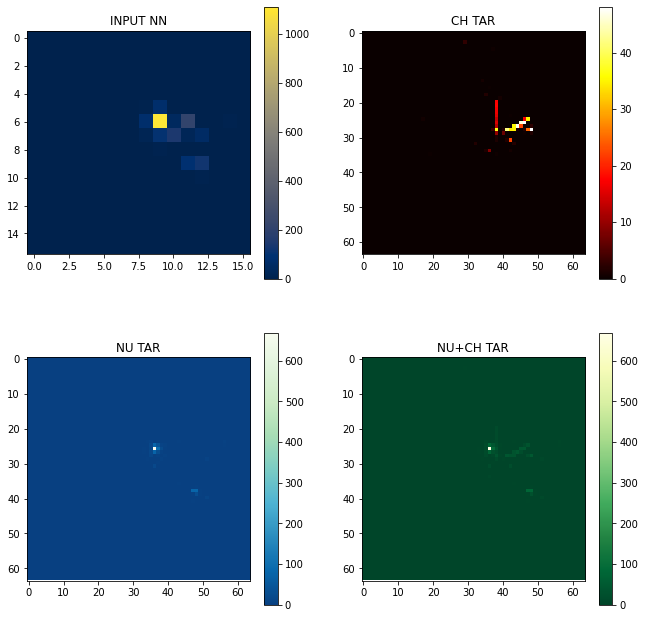

In [18]:
ev, l = 23, 1
print(LayerPix)
plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.title("INPUT NN")
plt.imshow(input_Layer[ev][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(222)
plt.title("CH TAR")
plt.imshow(targ_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(223)
plt.title("NU TAR")
plt.imshow(targ_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(224)
plt.title("NU+CH TAR")
plt.imshow(targ_nu[ev][l].T+targ_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.show()

In [19]:
train_size, val_size = int(0.8 * NEvent), int(0.2 * NEvent)
test_size = NEvent - (train_size + val_size)
indices = list(range(NEvent))
np.random.shuffle(indices)

In [20]:
input_Layer = input_Layer[indices]
targ_ch     = targ_ch[indices]
targ_nu     = targ_nu[indices]

#target_Layer = target_Layer[indices]

train_Layer, val_Layer = input_Layer[0:train_size], input_Layer[train_size: train_size + val_size]
train_ch, val_ch       =     targ_ch[0:train_size],     targ_ch[train_size: train_size + val_size]
train_nu, val_nu       =     targ_nu[0:train_size],     targ_nu[train_size: train_size + val_size]
#train_tot, val_tot = targ_ch[0:train_size], targ_ch[train_size: train_size + val_size]

#train_SupLayer, val_SupLayer = target_Layer[0:train_size], target_Layer[train_size: train_size + val_size]



In [21]:
np.save("numpy_fil/train_Layer.npy",train_Layer)
np.save("numpy_fil/val_Layer.npy",val_Layer)
np.save("numpy_fil/train_ch.npy",train_ch)
np.save("numpy_fil/val_ch.npy",val_ch)
np.save("numpy_fil/train_nu.npy",train_nu)
np.save("numpy_fil/val_nu.npy",val_nu)


[64 16]


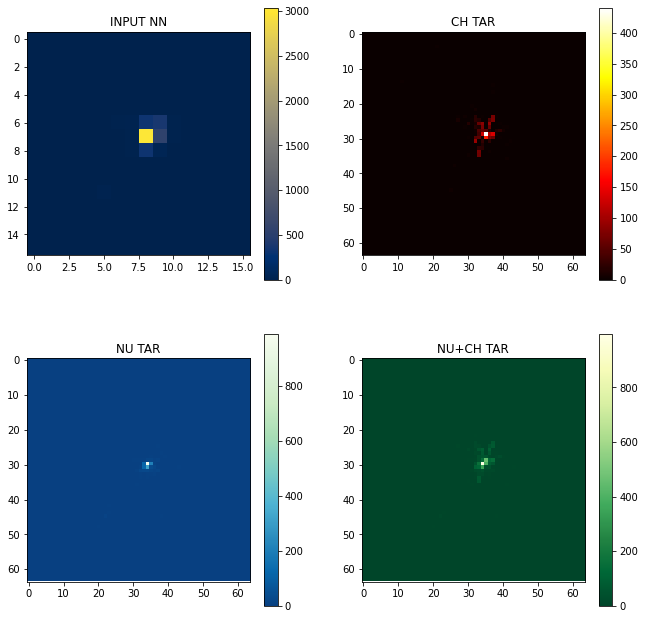

In [22]:
ev, l = 23, 1
print(LayerPix)
plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.title("INPUT NN")
plt.imshow(val_Layer[ev][l][:LayerPix[l],:LayerPix[l]].T, cmap = "cividis")
plt.colorbar()

plt.subplot(222)
plt.title("CH TAR")
plt.imshow(val_ch[ev][l].T, cmap="hot")
plt.colorbar()

plt.subplot(223)
plt.title("NU TAR")
plt.imshow(val_nu[ev][l].T, cmap="GnBu_r")
plt.colorbar()

plt.subplot(224)
plt.title("NU+CH TAR")
plt.imshow(val_nu[ev][l].T+val_ch[ev][l].T, cmap="YlGn_r")
plt.colorbar()

plt.show()